In [4]:
import os
import glob
import time
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor, ToPILImage

from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from tqdm import tqdm # Progress bar

In [5]:
# --- Configuration ---
TRAIN_DIR = 'train_images/'
VAL_DIR = 'validation_images/'
TEST_DIR = 'test_images/'
MODEL_SAVE_PATH = 'noise2noise_unet.pth'
PLOT_SAVE_PATH = 'validation_psnr_plot.png'

# Training Hyperparameters
NUM_EPOCHS = 50  # Adjust as needed
BATCH_SIZE = 4   # Adjust based on your GPU memory (3050ti might need 2, 4, or maybe 8)
LEARNING_RATE = 1e-4
NOISE_LEVEL = 25 # Standard deviation of Gaussian noise (0-255 scale)
IMG_SIZE = (256, 256) # Resize images to this size for consistent input

# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
# --- Noise Function ---
def add_gaussian_noise(image_tensor, noise_level=25):
    """Adds Gaussian noise to a tensor image (range [0, 1])."""
    sigma = noise_level / 255.0
    noise = torch.randn_like(image_tensor) * sigma
    noisy_image = image_tensor + noise
    return torch.clamp(noisy_image, 0.0, 1.0)

# --- PSNR Calculation ---
def calculate_psnr(img1, img2):
    """Calculates PSNR between two tensors (range [0, 1])."""
    img1_np = img1.squeeze().cpu().numpy()
    img2_np = img2.squeeze().cpu().numpy()
    # Ensure images are in the range [0, 1] for skimage.metrics.psnr
    img1_np = np.clip(img1_np, 0, 1)
    img2_np = np.clip(img2_np, 0, 1)
    return psnr(img1_np, img2_np, data_range=1.0)

In [7]:
# --- Dataset ---
class NoiseDataset(Dataset):
    def __init__(self, image_dir, noise_level=25, transform=None, target_transform=None):
        self.image_files = sorted(glob.glob(os.path.join(image_dir, '*.*')))
        self.noise_level = noise_level
        self.transform = transform
        self.target_transform = target_transform # Usually the same as transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            # Load clean image
            clean_image = Image.open(img_path).convert('RGB') # Ensure 3 channels
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return dummy data or skip
            # For simplicity, let's load the first image if current one fails
            # A better approach would be error handling or skipping in the DataLoader collate_fn
            clean_image = Image.open(self.image_files[0]).convert('RGB')


        if self.transform:
            clean_image = self.transform(clean_image) # Should output a tensor in [0, 1]

        # Generate two different noisy versions for Noise2Noise training
        noisy_image_1 = add_gaussian_noise(clean_image, self.noise_level)
        noisy_image_2 = add_gaussian_noise(clean_image, self.noise_level)

        # For validation/testing, we often want the clean image too
        # We can return it, but the training loop logic needs to handle it
        return noisy_image_1, noisy_image_2, clean_image # Input, Target, Original Clean

# --- U-Net Model (Simplified) ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        def CBR(in_feat, out_feat, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_feat, out_feat, kernel_size, stride, padding),
                nn.BatchNorm2d(out_feat), # Added BatchNorm
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(256, 512), CBR(512, 512))

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256)) # 256 + 256 = 512 input
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128)) # 128 + 128 = 256 input
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))   # 64 + 64 = 128 input

        # Final Convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with Skip Connections
        d3 = self.upconv3(b)
        # print("d3 shape:", d3.shape, "e3 shape:", e3.shape) # Debug shape issues
        # Potential resizing needed if shapes don't match exactly due to pooling/convs
        diffY = e3.size()[2] - d3.size()[2]
        diffX = e3.size()[3] - d3.size()[3]
        d3 = nn.functional.pad(d3, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        diffY = e2.size()[2] - d2.size()[2]
        diffX = e2.size()[3] - d2.size()[3]
        d2 = nn.functional.pad(d2, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        diffY = e1.size()[2] - d1.size()[2]
        diffX = e1.size()[3] - d1.size()[3]
        d1 = nn.functional.pad(d1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])

        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return out

In [8]:
# --- Training Function ---
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for noisy_img1, noisy_img2, _ in pbar: # We don't need clean_img for N2N training loss
        noisy_img1, noisy_img2 = noisy_img1.to(device), noisy_img2.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_img1)
        loss = criterion(outputs, noisy_img2) # N2N: Predict noisy_img2 from noisy_img1
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_img1.size(0)
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [9]:
# --- Testing Function ---
def test_single_image(model, image_path, device, noise_level, transform_fn):
    print(f"\n--- Testing Image: {os.path.basename(image_path)} ---")
    model.eval() # Set model to evaluation mode

    # Load clean image
    try:
        clean_image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Test image not found at {image_path}")
        return
    except Exception as e:
        print(f"Error loading test image {image_path}: {e}")
        return

    clean_tensor = transform_fn(clean_image).unsqueeze(0).to(device) # Add batch dim

    # Create a noisy version for input
    noisy_input = add_gaussian_noise(clean_tensor.squeeze(0), noise_level).unsqueeze(0) # Remove and add batch dim

    # Denoise
    with torch.no_grad():
        denoised_output = model(noisy_input)

    # Clamp output to valid range [0, 1]
    denoised_output = torch.clamp(denoised_output, 0.0, 1.0)

    # Calculate PSNR
    psnr_val = calculate_psnr(denoised_output.squeeze(0), clean_tensor.squeeze(0))
    print(f"PSNR (Denoised vs Original): {psnr_val:.2f} dB")

    # Convert tensors to PIL images for display
    to_pil = ToPILImage()
    noisy_pil = to_pil(noisy_input.squeeze(0).cpu())
    clean_pil = to_pil(clean_tensor.squeeze(0).cpu())
    denoised_pil = to_pil(denoised_output.squeeze(0).cpu())

    # Display side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(noisy_pil)
    axes[0].set_title(f'Noisy Input (Sigma={noise_level})')
    axes[0].axis('off')

    axes[1].imshow(clean_pil)
    axes[1].set_title('Original Clean Image')
    axes[1].axis('off')

    axes[2].imshow(denoised_pil)
    axes[2].set_title(f'Denoised Output (PSNR: {psnr_val:.2f} dB)')
    axes[2].axis('off')

    plt.suptitle(f'Denoising Result for {os.path.basename(image_path)}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()



In [10]:
# --- Validation Function ---
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_psnr = 0.0
    count = 0
    pbar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for noisy_img1, _, clean_img in pbar: # Input is noisy, compare output to CLEAN image
            # Note: noisy_img1 is generated from clean_img in the dataset __getitem__
            # We don't use noisy_img2 here, only during training loss calculation.
            noisy_img1, clean_img = noisy_img1.to(device), clean_img.to(device)

            outputs = model(noisy_img1)
            loss = criterion(outputs, clean_img) # Validate against the clean target
            running_loss += loss.item() * noisy_img1.size(0)

            # Calculate PSNR for each image in the batch
            for i in range(outputs.size(0)):
                 # Ensure output is detached and moved to CPU for PSNR calculation
                denoised_img = torch.clamp(outputs[i], 0.0, 1.0)
                original_clean = clean_img[i]
                total_psnr += calculate_psnr(denoised_img, original_clean)
                count += 1
            pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    avg_psnr = total_psnr / count if count > 0 else 0
    return epoch_loss, avg_psnr


In [11]:
# Define Transforms
# Using Compose leads to errors if not handled carefully with multiple returns
# Simpler to apply resize and ToTensor directly
def transform(image):
    image = TF.resize(image, IMG_SIZE, interpolation=TF.InterpolationMode.BILINEAR)
    return TF.to_tensor(image) # Converts to [0, 1] tensor

In [12]:
# Create Datasets and DataLoaders
print("Creating Datasets...")
train_dataset = NoiseDataset(TRAIN_DIR, noise_level=NOISE_LEVEL, transform=transform)
val_dataset = NoiseDataset(VAL_DIR, noise_level=NOISE_LEVEL, transform=transform)

if not train_dataset:
    print(f"Error: No images found in {TRAIN_DIR}")
    exit()
if not val_dataset:
    print(f"Error: No images found in {VAL_DIR}")
    exit()


print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(val_dataset)} validation images.")

Creating Datasets...
Found 410 training images.
Found 80 validation images.


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Initialize Model, Optimizer, Loss
print("Initializing Model...")
model = UNet(in_channels=3, out_channels=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss() # Mean Squared Error is common for Noise2Noise

Initializing Model...


Starting Training...

--- Epoch 1/50 ---


Epoch 1 Summary:
  Train Loss: 0.0880
  Val Loss:   0.0085
  Val PSNR:   21.13 dB
  -> New best model saved with PSNR: 21.13 dB

--- Epoch 2/50 ---


Epoch 2 Summary:
  Train Loss: 0.0173
  Val Loss:   0.0044
  Val PSNR:   23.75 dB
  -> New best model saved with PSNR: 23.75 dB

--- Epoch 3/50 ---


Epoch 3 Summary:
  Train Loss: 0.0151
  Val Loss:   0.0044
  Val PSNR:   24.01 dB
  -> New best model saved with PSNR: 24.01 dB

--- Epoch 4/50 ---


Epoch 4 Summary:
  Train Loss: 0.0145
  Val Loss:   0.0033
  Val PSNR:   25.09 dB
  -> New best model saved with PSNR: 25.09 dB

--- Epoch 5/50 ---


Epoch 5 Summary:
  Train Loss: 0.0138
  Val Loss:   0.0045
  Val PSNR:   24.09 dB

--- Epoch 6/50 ---


Epoch 6 Summary:
  Train Loss: 0.0136
  Val Loss:   0.0030
  Val PSNR:   25.62 dB
  -> New best model saved with PSNR: 25.62 dB

--- Epoch 7/50 ---


Epoch 7 Summary:
  Train Loss: 0.0127
  Val Loss:   0.0027
  Val PSNR:   25.90 dB
  -> New best model saved with PSNR: 25.90 dB

--- Epoch 8/50 ---


Epoch 8 Summary:
  Train Loss: 0.0125
  Val Loss:   0.0027
  Val PSNR:   25.88 dB

--- Epoch 9/50 ---


Epoch 9 Summary:
  Train Loss: 0.0123
  Val Loss:   0.0025
  Val PSNR:   26.30 dB
  -> New best model saved with PSNR: 26.30 dB

--- Epoch 10/50 ---


Epoch 10 Summary:
  Train Loss: 0.0122
  Val Loss:   0.0026
  Val PSNR:   26.08 dB

--- Epoch 11/50 ---


Epoch 11 Summary:
  Train Loss: 0.0122
  Val Loss:   0.0025
  Val PSNR:   26.25 dB

--- Epoch 12/50 ---


Epoch 12 Summary:
  Train Loss: 0.0120
  Val Loss:   0.0023
  Val PSNR:   26.53 dB
  -> New best model saved with PSNR: 26.53 dB

--- Epoch 13/50 ---


Epoch 13 Summary:
  Train Loss: 0.0120
  Val Loss:   0.0027
  Val PSNR:   26.04 dB

--- Epoch 14/50 ---


Epoch 14 Summary:
  Train Loss: 0.0115
  Val Loss:   0.0022
  Val PSNR:   26.73 dB
  -> New best model saved with PSNR: 26.73 dB

--- Epoch 15/50 ---


Epoch 15 Summary:
  Train Loss: 0.0116
  Val Loss:   0.0026
  Val PSNR:   25.98 dB

--- Epoch 16/50 ---


Epoch 16 Summary:
  Train Loss: 0.0115
  Val Loss:   0.0021
  Val PSNR:   26.91 dB
  -> New best model saved with PSNR: 26.91 dB

--- Epoch 17/50 ---


Epoch 17 Summary:
  Train Loss: 0.0116
  Val Loss:   0.0021
  Val PSNR:   26.87 dB

--- Epoch 18/50 ---


Epoch 18 Summary:
  Train Loss: 0.0117
  Val Loss:   0.0030
  Val PSNR:   25.39 dB

--- Epoch 19/50 ---


Epoch 19 Summary:
  Train Loss: 0.0113
  Val Loss:   0.0021
  Val PSNR:   27.03 dB
  -> New best model saved with PSNR: 27.03 dB

--- Epoch 20/50 ---


Epoch 20 Summary:
  Train Loss: 0.0113
  Val Loss:   0.0023
  Val PSNR:   26.62 dB

--- Epoch 21/50 ---


Epoch 21 Summary:
  Train Loss: 0.0111
  Val Loss:   0.0022
  Val PSNR:   26.73 dB

--- Epoch 22/50 ---


Epoch 22 Summary:
  Train Loss: 0.0112
  Val Loss:   0.0019
  Val PSNR:   27.32 dB
  -> New best model saved with PSNR: 27.32 dB

--- Epoch 23/50 ---


Epoch 23 Summary:
  Train Loss: 0.0110
  Val Loss:   0.0020
  Val PSNR:   27.15 dB

--- Epoch 24/50 ---


Epoch 24 Summary:
  Train Loss: 0.0111
  Val Loss:   0.0019
  Val PSNR:   27.53 dB
  -> New best model saved with PSNR: 27.53 dB

--- Epoch 25/50 ---


Epoch 25 Summary:
  Train Loss: 0.0110
  Val Loss:   0.0020
  Val PSNR:   27.24 dB

--- Epoch 26/50 ---


Epoch 26 Summary:
  Train Loss: 0.0110
  Val Loss:   0.0019
  Val PSNR:   27.37 dB

--- Epoch 27/50 ---


Epoch 27 Summary:
  Train Loss: 0.0109
  Val Loss:   0.0021
  Val PSNR:   27.00 dB

--- Epoch 28/50 ---


Epoch 28 Summary:
  Train Loss: 0.0108
  Val Loss:   0.0021
  Val PSNR:   27.16 dB

--- Epoch 29/50 ---


Epoch 29 Summary:
  Train Loss: 0.0107
  Val Loss:   0.0023
  Val PSNR:   26.84 dB

--- Epoch 30/50 ---


Epoch 30 Summary:
  Train Loss: 0.0110
  Val Loss:   0.0021
  Val PSNR:   27.00 dB

--- Epoch 31/50 ---


Epoch 31 Summary:
  Train Loss: 0.0110
  Val Loss:   0.0019
  Val PSNR:   27.30 dB

--- Epoch 32/50 ---


Epoch 32 Summary:
  Train Loss: 0.0108
  Val Loss:   0.0021
  Val PSNR:   26.93 dB

--- Epoch 33/50 ---


Epoch 33 Summary:
  Train Loss: 0.0106
  Val Loss:   0.0017
  Val PSNR:   27.81 dB
  -> New best model saved with PSNR: 27.81 dB

--- Epoch 34/50 ---


Epoch 34 Summary:
  Train Loss: 0.0106
  Val Loss:   0.0019
  Val PSNR:   27.50 dB

--- Epoch 35/50 ---


Epoch 35 Summary:
  Train Loss: 0.0107
  Val Loss:   0.0020
  Val PSNR:   27.26 dB

--- Epoch 36/50 ---


Epoch 36 Summary:
  Train Loss: 0.0105
  Val Loss:   0.0019
  Val PSNR:   27.46 dB

--- Epoch 37/50 ---


Epoch 37 Summary:
  Train Loss: 0.0104
  Val Loss:   0.0019
  Val PSNR:   27.45 dB

--- Epoch 38/50 ---


Epoch 38 Summary:
  Train Loss: 0.0108
  Val Loss:   0.0022
  Val PSNR:   26.76 dB

--- Epoch 39/50 ---


Epoch 39 Summary:
  Train Loss: 0.0105
  Val Loss:   0.0018
  Val PSNR:   27.64 dB

--- Epoch 40/50 ---


Epoch 40 Summary:
  Train Loss: 0.0105
  Val Loss:   0.0018
  Val PSNR:   27.71 dB

--- Epoch 41/50 ---


Epoch 41 Summary:
  Train Loss: 0.0105
  Val Loss:   0.0019
  Val PSNR:   27.52 dB

--- Epoch 42/50 ---


Epoch 42 Summary:
  Train Loss: 0.0106
  Val Loss:   0.0020
  Val PSNR:   27.10 dB

--- Epoch 43/50 ---


Epoch 43 Summary:
  Train Loss: 0.0104
  Val Loss:   0.0017
  Val PSNR:   27.83 dB
  -> New best model saved with PSNR: 27.83 dB

--- Epoch 44/50 ---


Epoch 44 Summary:
  Train Loss: 0.0105
  Val Loss:   0.0019
  Val PSNR:   27.31 dB

--- Epoch 45/50 ---


Epoch 45 Summary:
  Train Loss: 0.0103
  Val Loss:   0.0018
  Val PSNR:   27.65 dB

--- Epoch 46/50 ---


Epoch 46 Summary:
  Train Loss: 0.0102
  Val Loss:   0.0025
  Val PSNR:   27.06 dB

--- Epoch 47/50 ---


Epoch 47 Summary:
  Train Loss: 0.0103
  Val Loss:   0.0017
  Val PSNR:   27.84 dB
  -> New best model saved with PSNR: 27.84 dB

--- Epoch 48/50 ---


Epoch 48 Summary:
  Train Loss: 0.0104
  Val Loss:   0.0017
  Val PSNR:   27.91 dB
  -> New best model saved with PSNR: 27.91 dB

--- Epoch 49/50 ---


Epoch 49 Summary:
  Train Loss: 0.0106
  Val Loss:   0.0019
  Val PSNR:   27.31 dB

--- Epoch 50/50 ---


Epoch 50 Summary:
  Train Loss: 0.0103
  Val Loss:   0.0016
  Val PSNR:   28.04 dB
  -> New best model saved with PSNR: 28.04 dB

Training finished in 19.88 minutes.
Best Validation PSNR: 28.04 dB
Model saved to noise2noise_unet.pth
Plotting PSNR curve...
PSNR plot saved to validation_psnr_plot.png


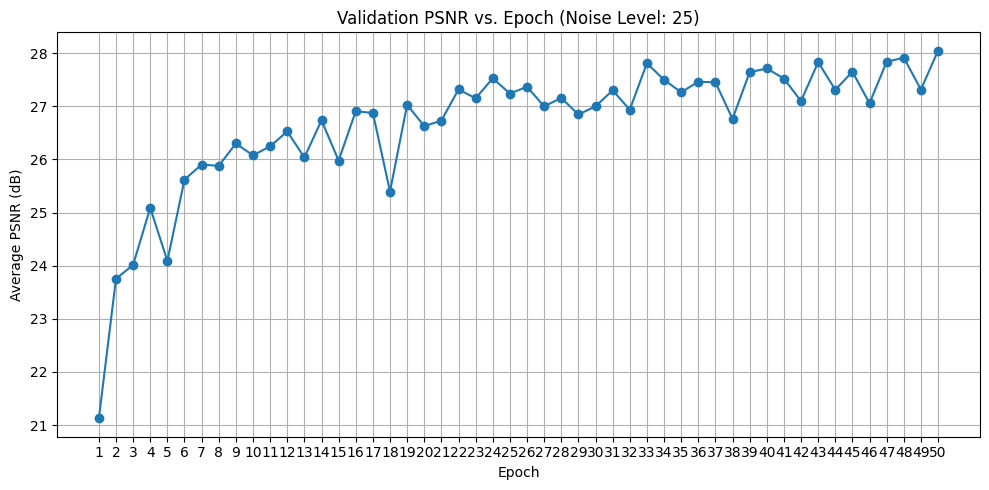

In [14]:
# Training Loop
best_val_psnr = 0.0
val_psnr_history = []
train_loss_history = []
val_loss_history = []

print("Starting Training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_psnr = validate_epoch(model, val_loader, criterion, DEVICE)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_psnr_history.append(val_psnr)

    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val PSNR:   {val_psnr:.2f} dB")

    # Save the model if validation PSNR improves
    if val_psnr > best_val_psnr:
        best_val_psnr = val_psnr
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  -> New best model saved with PSNR: {best_val_psnr:.2f} dB")

end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")
print(f"Best Validation PSNR: {best_val_psnr:.2f} dB")
print(f"Model saved to {MODEL_SAVE_PATH}")

# Plotting Validation PSNR Curve
print("Plotting PSNR curve...")
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), val_psnr_history, marker='o', linestyle='-')
plt.title(f'Validation PSNR vs. Epoch (Noise Level: {NOISE_LEVEL})')
plt.xlabel('Epoch')
plt.ylabel('Average PSNR (dB)')
plt.grid(True)
plt.xticks(range(1, NUM_EPOCHS + 1)) # Ensure integer ticks for epochs
plt.tight_layout()
plt.savefig(PLOT_SAVE_PATH)
print(f"PSNR plot saved to {PLOT_SAVE_PATH}")
# plt.show() # Optional: display plot immediately




Loading best model from noise2noise_unet.pth for testing...
Model loaded successfully.

--- Testing Image: 491.jpg ---
PSNR (Denoised vs Original): 26.36 dB


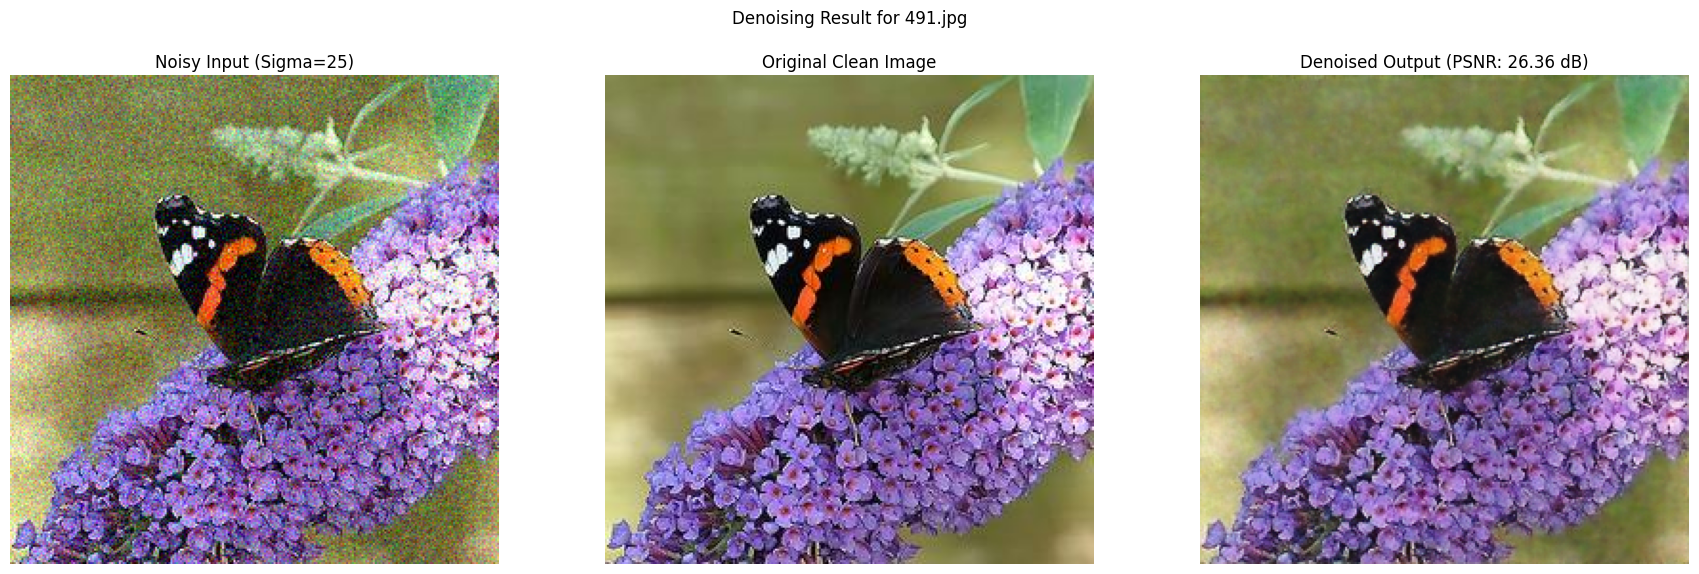


--- Testing Image: 493.jpg ---
PSNR (Denoised vs Original): 27.59 dB


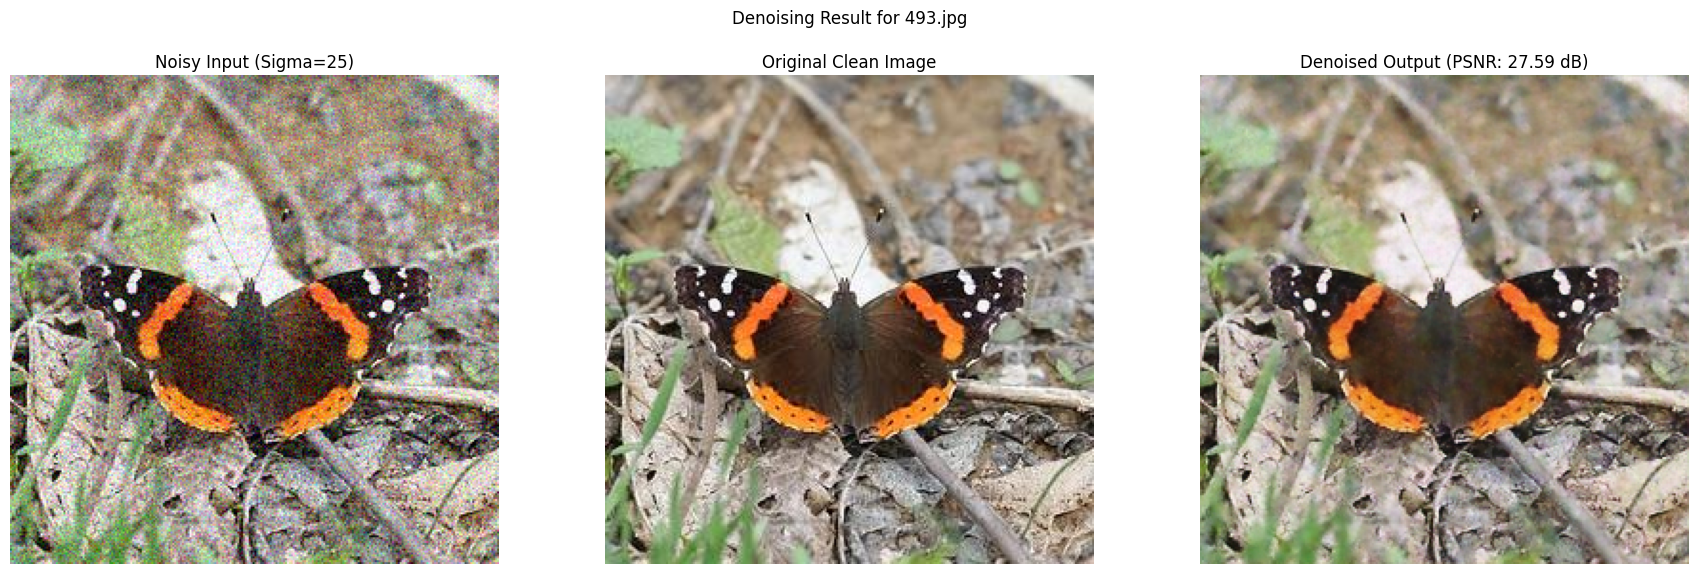


--- Testing Image: 496.jpg ---
PSNR (Denoised vs Original): 27.56 dB


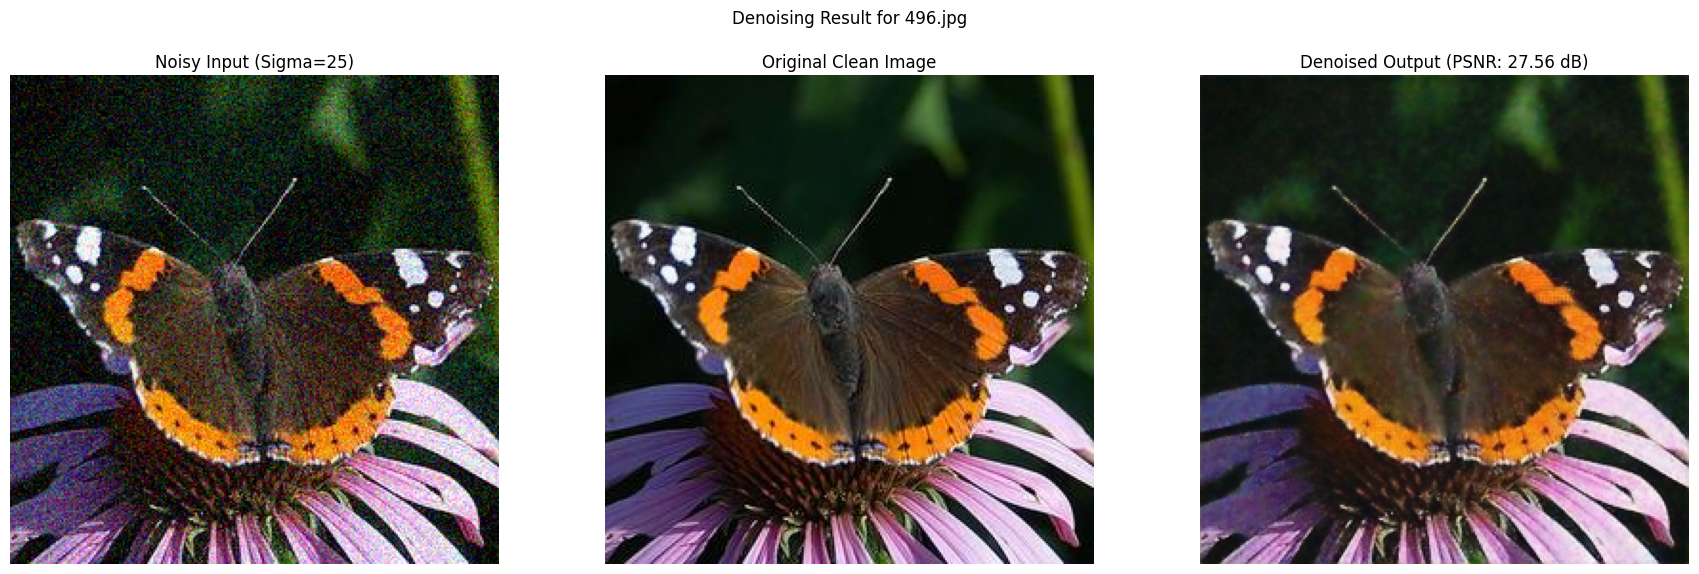


Script finished.


In [16]:
# --- User Interaction for Testing ---
# Load the best model for testing
print(f"\nLoading best model from {MODEL_SAVE_PATH} for testing...")
test_model = UNet(in_channels=3, out_channels=3).to(DEVICE)
try:
    test_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print("Model loaded successfully.")

    while True:
        try:
            test_image_name = input(f"\nEnter the filename of an image in '{TEST_DIR}' to denoise (or type 'quit'): ")
            if test_image_name.lower() == 'quit':
                break
            test_image_path = os.path.join(TEST_DIR, test_image_name)
            if not os.path.exists(test_image_path):
                print(f"Error: File '{test_image_name}' not found in '{TEST_DIR}'. Please try again.")
                # Optional: List available test files
                available_files = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]
                if available_files:
                    print("Available files:", ", ".join(available_files[:5]) + ('...' if len(available_files) > 5 else ''))
                else:
                    print(f"No files found in {TEST_DIR}")
                continue

            test_single_image(test_model, test_image_path, DEVICE, NOISE_LEVEL, transform)

        except KeyboardInterrupt:
            print("\nExiting test loop.")
            break
        except Exception as e:
            print(f"An error occurred during testing: {e}")
            # Optionally add more robust error handling or logging here

except FileNotFoundError:
        print(f"Error: Could not load model from {MODEL_SAVE_PATH}. Was training run successfully?")
except Exception as e:
    print(f"An unexpected error occurred loading the model or during testing: {e}")

print("\nScript finished.")